In [225]:
import pandas as pd
import numpy as np
import os
import altair as alt
import nbconvert
import time
from datetime import datetime

In [226]:
# %load_ext rpy2.ipython              # Enabling R & Python

## Creating a DF of activities
### Description 
* My list is a
* The list a contains 295 elements [index 0:294]
* Each of the 295 elements contains 5 sub-elements [index 0:4]
* a[i] give all 5 sub-elements
* a[i][j] gives 1 sub-element 
* Each element a[i][0] contains the following 'DESCRIPTION,m/d/Y,startTime,endTime'

### Loop 1
* Iterate through all a[i][0] values and add there to a new list ('tempStringList')

### Challenge: Storing time series data
Representing time series (esp. tick data) using elaborate data structures may be not the best idea. You may want to try to use two arrays of the same length to store your time series. The first array stores values (e.g. price) and the second array stores time. Note that the second series is monotonically increasing (or at least non-decreasing), i.e. it's sorted. This property enables you to search it using the binary search algorithm. Once you get an index of a time of interest in the second array you also have the index of the relevant entry in the first array. If you wrap the two arrays and the search algorithm e.g. in a class you will have the whole implementation complexity hidden behind a simple interface.
https://quant.stackexchange.com/questions/613/what-is-the-best-data-structure-implementation-for-representing-a-time-series

Briefly, using universal time was considered, however, this was deemed unesscesary, as the time of day (from the context of the individual) provides context for the data
* Array 

 Attribute       | Format                | Description
----------       | ----------------      | ---------------------- 
Timestamp        | `YYYY-MM-DD hh:mm:ss` | ...
Washine Machine  | `Boolean`             | ...

---

## The Activities Data
### Importing the Activities Data
The file `S1Activities.csv` contains a tabulated summary of Heading, Category, Subcategory and a corresponding code.

At this time, the activities data will not be subject to preprocessing.

---

## The Activities Data Set
### S1 - comment
### S2 - comment
<p style='text-align: justify;'> 
The activities data set `S1activities.csv` will be imported, evaluated and cleaned. The goal of the pre-processing will be
to restructure the dataset into a 'tidy' format, that is, where the attributes are columns, the rows are instances, and each cell contains only one value. Given that the data is time-series, timestamps will be used as indexes. The data will also be cast into continuous 24 hour segments, with timestamps in the form `YYYY-MM-DD hh:mm:ss` (using datetime data type)

We aim to perform the preprocessing in such a way that is
* minimally computationally intensive
* reproducible / traceable code
* reasonable checks (validation)
</p>

### Importing the Data
<p style='text-align: justify;'> 
The activities data was imported into an indexed dataframe, containing only one column, with 1475 rows, with all values comma-separated (per row). This style of import had to be used, due to the varying number of comma-separated elements in each row (as seen in figure X, above).
</p>

In [242]:
dsS1 = pd.read_csv('S1activities_data.csv', sep = 'delimiter', header = None)

/Users/alistairgj/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [243]:
dsS1.head(n=10)

0
0                 Bathing,4/1/2003,20:41:35,21:32:50
1  100,68,81,101,93,137,93,58,57,67,93,58,68,88,5...
2  Toilet Flush,Sink faucet - hot,Closet,Light sw...
3  20:51:52,20:51:58,20:53:36,20:53:49,20:53:52,2...
4  21:5:20,20:52:5,20:53:43,21:21:43,20:58:42,20:...
5               Toileting,4/1/2003,17:30:36,17:46:41
6                                             100,68
7                     Toilet Flush,Sink faucet - hot
8                                  17:39:37,17:39:46
9                                  18:10:57,17:39:52

In [244]:
# Confirming the length of the dataframe
len(dsS1)

1475

### Converting the Dataframe to an Array
<p style='text-align: justify;'> 
As mentioned above, in order to work with these data, they need to be in a 'tidy' format [ref], that is, the attributes are columns, the rows are instances, and each cell contains only one value. 
* Note: An array of arrays
* An array where each element is an array (list?)
* Between each increment of 5 (0 - 4), the sub-arrays have different lengths
Table [ref], below, contains a summary of the data structure after the operation `np.array(dsS1)` is performed. In order to continue pre-processing, the array had to be flattened from a 2D structure to a 1D structure, using `flatten()`.
</p>

In [245]:
a = np.array(dsS1)

In [246]:
i = 0
while i < 5:
    print(a[i])
    i += 1

['Bathing,4/1/2003,20:41:35,21:32:50']
['100,68,81,101,93,137,93,58,57,67,93,58,68,88,57,67,100,68,67,76']
['Toilet Flush,Sink faucet - hot,Closet,Light switch,Shower faucet,Freezer,Shower faucet,Medicine cabinet,Medicine cabinet,Cabinet,Shower faucet,Medicine cabinet,Sink faucet - hot,Sink faucet - cold,Medicine cabinet,Cabinet,Toilet Flush,Sink faucet - hot,Cabinet,Lamp']
['20:51:52,20:51:58,20:53:36,20:53:49,20:53:52,20:58:22,20:58:43,21:5:23,21:5:46,21:5:47,21:18:34,21:18:55,21:19:41,21:20:4,21:20:38,21:20:39,21:21:13,21:21:16,21:21:37,21:22:8']
['21:5:20,20:52:5,20:53:43,21:21:43,20:58:42,20:58:32,21:6:9,21:5:45,21:18:55,21:5:49,21:18:35,21:20:37,21:20:5,21:20:34,21:21:41,21:20:42,23:10:23,21:21:23,21:21:38,23:11:8']


<p style='text-align: justify;'> 
* The DF has been converted into a 2D array of, where each element is an array with 1 element
* Each 

Index (a[i]) | Type                           | Description            | Desired Type
----------   | ----------------               | ---------------------- | ---------------------- 
0            | An array of comma-sep strings  | Activity information, date, start time, end time | ...
1            | An array of comma-sep strings  | Sub-activity reference value    | Levels
2            | An array of comma-sep strings  | Sub-activity descriptive value  | Levels
3            | An array of comma-sep strings  | Sub-activity start time   | Datetime including the date extracted from the index 3 rows above
4            | An array of comma-sep strings  | Sub-activity end time     | Datetime including the date extracted from the index 4 rows above

</p>

In [247]:
# Flattening the 2D array to a 1D array
a = a.flatten()

In [248]:
# Printing 5 elements of the 1D array
i = 0 
while i < 5:
    print(a[i])
    i += 1

Bathing,4/1/2003,20:41:35,21:32:50
100,68,81,101,93,137,93,58,57,67,93,58,68,88,57,67,100,68,67,76
Toilet Flush,Sink faucet - hot,Closet,Light switch,Shower faucet,Freezer,Shower faucet,Medicine cabinet,Medicine cabinet,Cabinet,Shower faucet,Medicine cabinet,Sink faucet - hot,Sink faucet - cold,Medicine cabinet,Cabinet,Toilet Flush,Sink faucet - hot,Cabinet,Lamp
20:51:52,20:51:58,20:53:36,20:53:49,20:53:52,20:58:22,20:58:43,21:5:23,21:5:46,21:5:47,21:18:34,21:18:55,21:19:41,21:20:4,21:20:38,21:20:39,21:21:13,21:21:16,21:21:37,21:22:8
21:5:20,20:52:5,20:53:43,21:21:43,20:58:42,20:58:32,21:6:9,21:5:45,21:18:55,21:5:49,21:18:35,21:20:37,21:20:5,21:20:34,21:21:41,21:20:42,23:10:23,21:21:23,21:21:38,23:11:8


In [249]:
a[0][0]                                               # Checking first element of the first element

'B'

In [250]:
i = 0
while i < 10:                                         # While loop to iterate 10 times
    print(a[0][i])                                    # Printing the a[0][i] element
    i += 1

B
a
t
h
i
n
g
,
4
/


<p style='text-align: justify;'> 
* A array of strings, instead of an array of arrays
Analysis of the original dataset, and exploration during pre-processing to this point, shows us that the original dataset follows a structure such that each 5 rows of data contains is one discrete set of data. In this structure,
* Row 1 = Activity, Date, Start Time, End Time
* Row 2 = Sub-activity (an action that can be executed as part of performing the activity) code-values
* Row 3 = Sub-activity descriptive values
* Row 4 = Sub-activity start time
* Row 5 = Sub-activity end time
In order to access the values programmatically, we will now turn the 1D array list back into a 2D array list, where each element array[i] contains the 5 rows of information, as described above. 
</p>

#### Chunking the flattened array
Chucking the 1D array back into a 2D array allows us to more easily use loops to extract the required values.

In [251]:
from more_itertools import chunked                     # Importing the required packages
a = list(chunked(a, 5))                                # Chunking the array by a unit of 5 

#### Looping on a[i]
* We will continue to perform sanity checks during the pre-processing
* Here we loop through values a[i] from i = 0 till i = 4
* We can see that we have successfully structured the data such that each element ...

In [252]:
i = 0
while i < 5:                                        # While loop to iterate 5 times
    print(a[i])                                     # Printing the a[i] element
    i += 1

['Bathing,4/1/2003,20:41:35,21:32:50', '100,68,81,101,93,137,93,58,57,67,93,58,68,88,57,67,100,68,67,76', 'Toilet Flush,Sink faucet - hot,Closet,Light switch,Shower faucet,Freezer,Shower faucet,Medicine cabinet,Medicine cabinet,Cabinet,Shower faucet,Medicine cabinet,Sink faucet - hot,Sink faucet - cold,Medicine cabinet,Cabinet,Toilet Flush,Sink faucet - hot,Cabinet,Lamp', '20:51:52,20:51:58,20:53:36,20:53:49,20:53:52,20:58:22,20:58:43,21:5:23,21:5:46,21:5:47,21:18:34,21:18:55,21:19:41,21:20:4,21:20:38,21:20:39,21:21:13,21:21:16,21:21:37,21:22:8', '21:5:20,20:52:5,20:53:43,21:21:43,20:58:42,20:58:32,21:6:9,21:5:45,21:18:55,21:5:49,21:18:35,21:20:37,21:20:5,21:20:34,21:21:41,21:20:42,23:10:23,21:21:23,21:21:38,23:11:8']
['Toileting,4/1/2003,17:30:36,17:46:41', '100,68', 'Toilet Flush,Sink faucet - hot', '17:39:37,17:39:46', '18:10:57,17:39:52']
['Toileting,4/1/2003,18:4:43,18:18:2', '68,107', 'Sink faucet - hot,Light switch', '18:11:2,18:12:28', '18:11:13,21:21:53']
['Toileting,4/1/2003,

#### Looping on a[0][i]
* This give us access to XYZ data

In [253]:
i = 0
while i < 5:                                        # While loop to iterate 5 times
    print(a[0][i])                                  # Printing the a[0][i] element
    i += 1

Bathing,4/1/2003,20:41:35,21:32:50
100,68,81,101,93,137,93,58,57,67,93,58,68,88,57,67,100,68,67,76
Toilet Flush,Sink faucet - hot,Closet,Light switch,Shower faucet,Freezer,Shower faucet,Medicine cabinet,Medicine cabinet,Cabinet,Shower faucet,Medicine cabinet,Sink faucet - hot,Sink faucet - cold,Medicine cabinet,Cabinet,Toilet Flush,Sink faucet - hot,Cabinet,Lamp
20:51:52,20:51:58,20:53:36,20:53:49,20:53:52,20:58:22,20:58:43,21:5:23,21:5:46,21:5:47,21:18:34,21:18:55,21:19:41,21:20:4,21:20:38,21:20:39,21:21:13,21:21:16,21:21:37,21:22:8
21:5:20,20:52:5,20:53:43,21:21:43,20:58:42,20:58:32,21:6:9,21:5:45,21:18:55,21:5:49,21:18:35,21:20:37,21:20:5,21:20:34,21:21:41,21:20:42,23:10:23,21:21:23,21:21:38,23:11:8


#### Looping on a[i][0]
* This give us access to XYZ data

In [254]:
i = 0
while i < 25:                                      
    print(a[i][0])                                 # Printing the a[0][i] element
    i += 5

Bathing,4/1/2003,20:41:35,21:32:50
Preparing lunch,4/1/2003,11:21:17,11:38:22
Going out to work,4/1/2003,7:0:55,7:2:30
Preparing a snack,4/2/2003,17:6:21,17:12:1
Preparing breakfast,4/2/2003,7:21:12,8:10:40


#### Confirming the outer loop elements

In [255]:
## Lenght
dimLength = []
i = 0
while i < len(a):
    dimLength.append(len(a[i]))
    i = i + 1

In [256]:
len(dimLength)

295

### Extracting the Activity, Time and Data

If we run `a[0][0]`, we get `'Bathing,4/1/2003,20:41:35,21:32:50'`
* A string with 4 comma-separated 'items'
* We won't check the entire DF, rather, will rely on errors thrown back to confirm validity ('validation of the method')

In [257]:
a[0][0]                                        # Example extraction of element

'Bathing,4/1/2003,20:41:35,21:32:50'

#### Constructing the while loop
* Create empty lists
* Extracts the relevant elements
* Adds (appends) the elements to the lists
* 

In [258]:
tempStringList = []
tempStripList = []
activityList = []
dateList = []
tempStartTimeList = []
tempEndTimeList = []

i = 0
while i < len(dimLength):
    tempStringList.append(a[i][0])
    tempStripList.append([x.strip() for x in tempStringList[i].split(',')])
    activityList.append(tempStripList[i][0])
    dateList.append(tempStripList[i][1])
    tempStartTimeList.append(tempStripList[i][2])
    tempEndTimeList.append(tempStripList[i][3])
    i = i + 1

In [259]:
zippedList = list(zip(activityList, dateList, tempStartTimeList, tempEndTimeList))
cleanDF = pd.DataFrame(zippedList, columns = ['activity', 'date', 'startTime', 'endTime'])

In [260]:
start = (cleanDF.date + " " + cleanDF.startTime)
end = (cleanDF.date + " " + cleanDF.endTime)

In [261]:
startList = []
endList = []

i = 0
while i < len(start):
    startList.append(datetime.strptime(start[i], '%m/%d/%Y %H:%M:%S'))
    endList.append(datetime.strptime(end[i], '%m/%d/%Y %H:%M:%S'))
    i = i + 1

In [262]:
startList[0]

datetime.datetime(2003, 4, 1, 20, 41, 35)

In [263]:
zippedList = list(zip(activityList, startList, endList))
cleanDF = pd.DataFrame(zippedList, columns = ['activity', 'start', 'end'])
cleanDF.head(n=10)

activity               start                 end
0              Bathing 2003-04-01 20:41:35 2003-04-01 21:32:50
1            Toileting 2003-04-01 17:30:36 2003-04-01 17:46:41
2            Toileting 2003-04-01 18:04:43 2003-04-01 18:18:02
3            Toileting 2003-04-01 11:52:01 2003-04-01 11:58:50
4    Going out to work 2003-04-01 12:11:26 2003-04-01 12:15:12
5      Preparing lunch 2003-04-01 11:21:17 2003-04-01 11:38:22
6     Preparing dinner 2003-04-01 16:43:58 2003-04-01 17:07:57
7  Preparing breakfast 2003-04-01 06:36:18 2003-04-01 06:40:38
8             Dressing 2003-04-01 06:32:57 2003-04-01 06:36:05
9            Toileting 2003-04-01 06:07:15 2003-04-01 06:15:58

---

### Extracting the Sub-Activities

In [264]:
numericConcat = []
numericSep = []
actConcat = []
actSep = []
startConcat = []
startSep = []
endConcat = []
endSep = []

i = 0
while i < len(a):
    numericConcat.append(a[i][1])
    numericSep.append([x.strip() for x in numericConcat[i].split(',')])
    actConcat.append(a[i][2])
    actSep.append([x.strip() for x in actConcat[i].split(',')])
    startConcat.append(a[i][3])
    startSep.append([x.strip() for x in startConcat[i].split(',')])
    endConcat.append(a[i][4])
    endSep.append([x.strip() for x in endConcat[i].split(',')])
    i = i + 1

In [265]:
dateStringList = []

i = 0
while i < len(a):
    for x in range(len(numericSep[i])):
        dateStringList.append(dateList[i])
    i = i + 1

len(dateStringList)

2772

### Add table here for
* numericSep = (wrt the raw data)
* actSep = (wrt the raw dat)
* ...

In [277]:
subDF.dtypes

subActNum            object
subAct               object
start        datetime64[ns]
end          datetime64[ns]
dtype: object

In [278]:
##subDF['subActNum'] = pd.to_numeric(subDF['subActNum'])

In [ ]:
# ALL GOOD SO FAR

## Plotting the Initially Created DF

In [102]:
import matplotlib.pyplot as plt

/Users/alistairgj/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


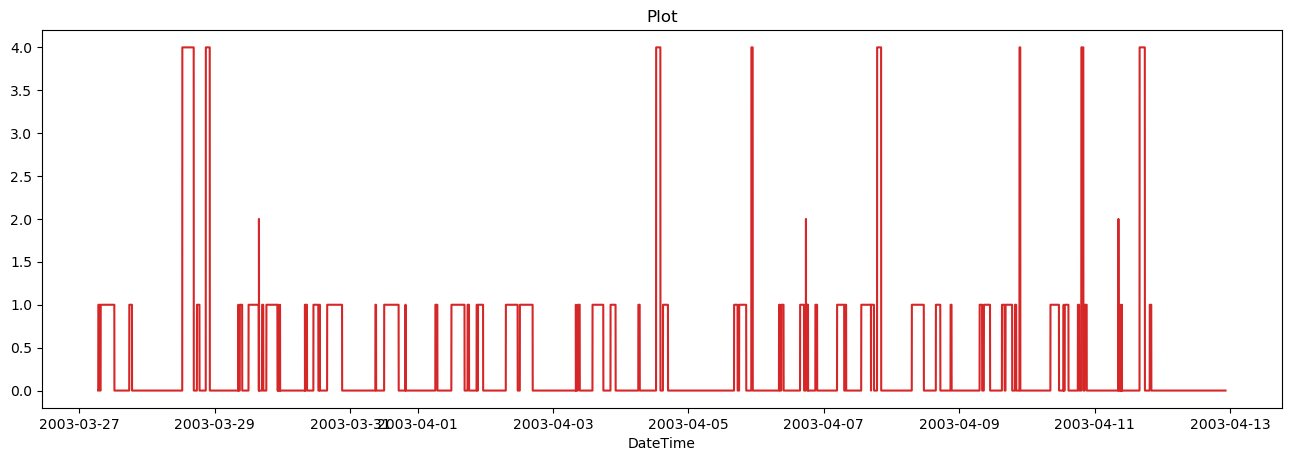

In [103]:
# Draw Plot
def plot_ds(df, x, y, title = "", xlabel = 'DateTime', ylabel = '', dpi = 100):
    plt.figure(figsize = (16,5), dpi = dpi)
    plt.plot(x, y, color = 'tab:red')
    plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
    plt.show()

plot_ds(df, x = df.index, y = df.subActNum_100, title = 'Plot')   
# Now just need to collapse this down into months

* Values greater than 1 are attributed to duplication in the original dataset
* Values greater than 1 represent only x% - extremely insignificant
* All values greater than 1 will be converted to 1

In [104]:
maxValues = df.max()                                                # Checking for max values in df

In [105]:
maxValues.max()                                                     # The maximum value of max values

8.0

In [106]:
df = df.replace(to_replace =[2, 3, 4, 5, 6, 7, 8], value = 1) 

In [107]:
maxValues = df.max()
maxValues.max()

1.0

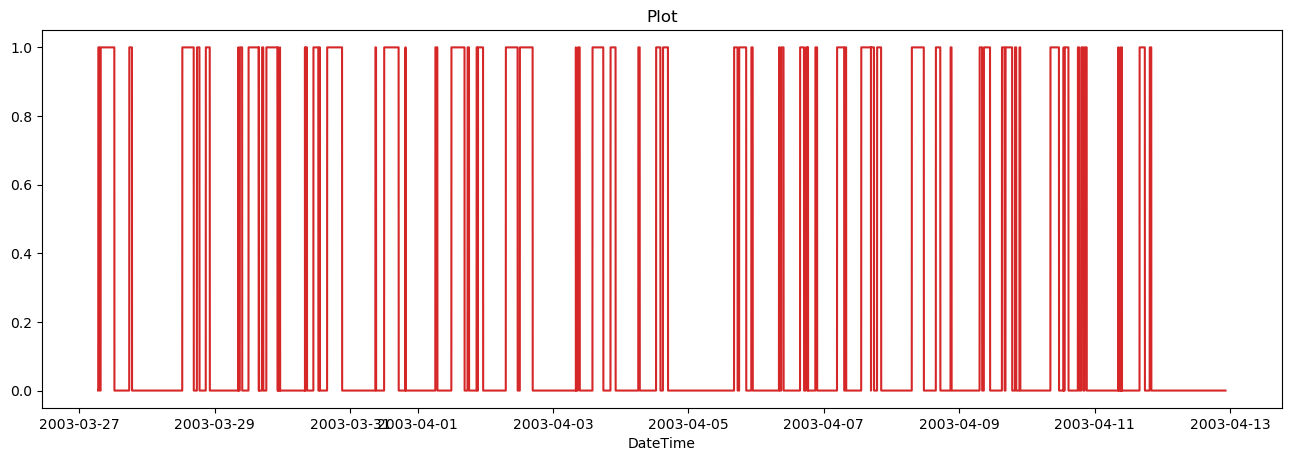

In [108]:
# Draw Plot
def plot_ds(df, x, y, title = "", xlabel = 'DateTime', ylabel = '', dpi = 100):
    plt.figure(figsize = (16,5), dpi = dpi)
    plt.plot(x, y, color = 'tab:red')
    plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
    plt.show()

plot_ds(df, x = df.index, y = df.subActNum_100, title = 'Plot')   
# Now just need to collapse this down into months

In [109]:
df.index                                                           # Checking the index (structure)

DatetimeIndex(['2003-03-27 06:43:40', '2003-03-27 06:43:41',
               '2003-03-27 06:43:42', '2003-03-27 06:43:43',
               '2003-03-27 06:43:44', '2003-03-27 06:43:45',
               '2003-03-27 06:43:46', '2003-03-27 06:43:47',
               '2003-03-27 06:43:48', '2003-03-27 06:43:49',
               ...
               '2003-04-12 22:23:56', '2003-04-12 22:23:57',
               '2003-04-12 22:23:58', '2003-04-12 22:23:59',
               '2003-04-12 22:24:00', '2003-04-12 22:24:01',
               '2003-04-12 22:24:02', '2003-04-12 22:24:03',
               '2003-04-12 22:24:04', '2003-04-12 22:24:05'],
              dtype='datetime64[ns]', length=1438826, freq=None)

In [110]:
dayOfAct = df.index.dayofweek.astype(str)
df['dayOfAct'] = dayOfAct
df['dayOfAct'].replace(['0','1','2','3','4','5','6'],['mon','tue','wed','thu','fri','sat','sun'], inplace = True)
df['weekday_weekend'] = df['dayOfAct']
df['weekday_weekend'].replace(['mon','tue','wed','thu','fri','sat','sun'],
                              ['weekday','weekday','weekday','weekday','weekday','weekend','weekend'], inplace = True)

In [111]:
hourOfAct = df.index.hour.astype(str)
df['hourOfAct'] = hourOfAct
df['hourOfAct'].replace(['1','2','3','4','5','6','7','8',
                         '9','10','11','12','13','14','15','16','17',
                         '18','19','20','21','22','23','24'],
                        ['24till2','24till2','24till2','3till5','3till5','3till5',
                         '6till8','6till8','6till8', '9till11','9till11','9till11',
                         '12till14','12till14','12till14','15till17','15till17','15till17',
                         '18till20','18till20','18till20','21till23','21till23','21till23'], inplace = True)

In [112]:
uniqueHours = hourOfAct.unique

In [113]:
uniqueHours
# Need to remove / change index...

<bound method Index.unique of Index(['6', '6', '6', '6', '6', '6', '6', '6', '6', '6',
       ...
       '22', '22', '22', '22', '22', '22', '22', '22', '22', '22'],
      dtype='object', length=1438826)>

In [114]:
df.to_csv('final_with_cat.csv',index=True)

## Discuss Feature Engineering

In [115]:
df.head(n=3)

subActNum_100  subActNum_101  subActNum_104  \
2003-03-27 06:43:40            0.0            0.0            0.0   
2003-03-27 06:43:41            0.0            0.0            0.0   
2003-03-27 06:43:42            0.0            0.0            0.0   

                     subActNum_105  subActNum_106  subActNum_107  \
2003-03-27 06:43:40            0.0            0.0            0.0   
2003-03-27 06:43:41            0.0            0.0            0.0   
2003-03-27 06:43:42            0.0            0.0            0.0   

                     subActNum_108  subActNum_118  subActNum_119  \
2003-03-27 06:43:40            0.0            0.0            0.0   
2003-03-27 06:43:41            0.0            0.0            0.0   
2003-03-27 06:43:42            0.0            0.0            0.0   

                     subActNum_120  ...  subActNum_93  subActNum_94  \
2003-03-27 06:43:40            0.0  ...           0.0           0.0   
2003-03-27 06:43:41            0.0  ...           0.0           0.0   
2003-03-27 06:43:42            0.0  ...           0.0           0.0   

                     subActNum_95  subActNum_96  subActNum_97  subActNum_98  \
2003-03-27 06:43:40           0.0           0.0           0.0           0.0   
2003-03-27 06:43:41           0.0           0.0           0.0           0.0   
2003-03-27 06:43:42           0.0           0.0           0.0           0.0   

                     subActNum_99  dayOfAct  weekday_weekend  hourOfAct  
2003-03-27 06:43:40           0.0       thu          weekday     3till5  
2003-03-27 06:43:41           0.0       thu          weekday     3till5  
2003-03-27 06:43:42           0.0       thu          weekday     3till5  

[3 rows x 75 columns]

In [116]:
#mylist = new.index
#mylist = list(dict.fromkeys(mylist))
#df.replace(to_replace =["Boston Celtics", "Texas"], value ="Omega Warrior") 
#df['dayOfAct'].replace('0','Mon',inplace = True) 

## Collapse into minutes
* Use in-built Pandas function
* `resample('min').max()` 

#### Need to investigate missing values

In [211]:
resampleFreq = resampleFreq.dropna()

In [212]:
resampleFreq.to_csv('resampled_freq.csv',index=True)

In [256]:
resampleFreqMelt.to_csv('resampled_freq_melt.csv')

* Need the number of columns
* Need value for i columns - 1 as the DENOMINATOR [i-1][j] - not correct
* let a = number of columns (this will be the denominator) 
* Need value [i][j] as the NUMERATOR
* Outer loop = row reference - (while a > len)
* Inner loop = column reference

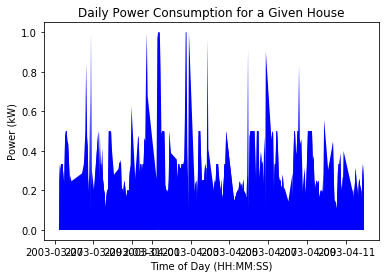

In [213]:
import matplotlib.pyplot as plt
import pandas as pd

#Build the dataframe described above

#fig, ax = plt.subplots()

for col in resampleFreq.columns:
  plt.fill_between(resampleFreq.index, 0, 
                   resampleFreq[col], facecolor='blue')
  plt.title('Daily Power Consumption for a Given House')      
  plt.ylabel('Power (kW)')
  plt.xlabel('Time of Day (HH:MM:SS)')
    
plt.show()

In [185]:
len(resampleFreq)

401

In [219]:
resampleFreqMelt = resampleFreq.stack().reset_index()
resampleFreqMelt.columns = ['TimeStamp', 'SubAct', 'Freq']

In [247]:
resampleFreqMelt.tail(n=10)

TimeStamp        SubAct      Freq
18278 2003-04-11 22:00:00  subActNum_90  0.000000
18279 2003-04-11 22:00:00  subActNum_91  0.000000
18280 2003-04-11 22:00:00  subActNum_92  0.000000
18281 2003-04-11 22:00:00  subActNum_93  0.000000
18282 2003-04-11 22:00:00  subActNum_94  0.000000
18283 2003-04-11 22:00:00  subActNum_95  0.183673
18284 2003-04-11 22:00:00  subActNum_96  0.000000
18285 2003-04-11 22:00:00  subActNum_97  0.000000
18286 2003-04-11 22:00:00  subActNum_98  0.000000
18287 2003-04-11 22:00:00  subActNum_99  0.000000

In [248]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

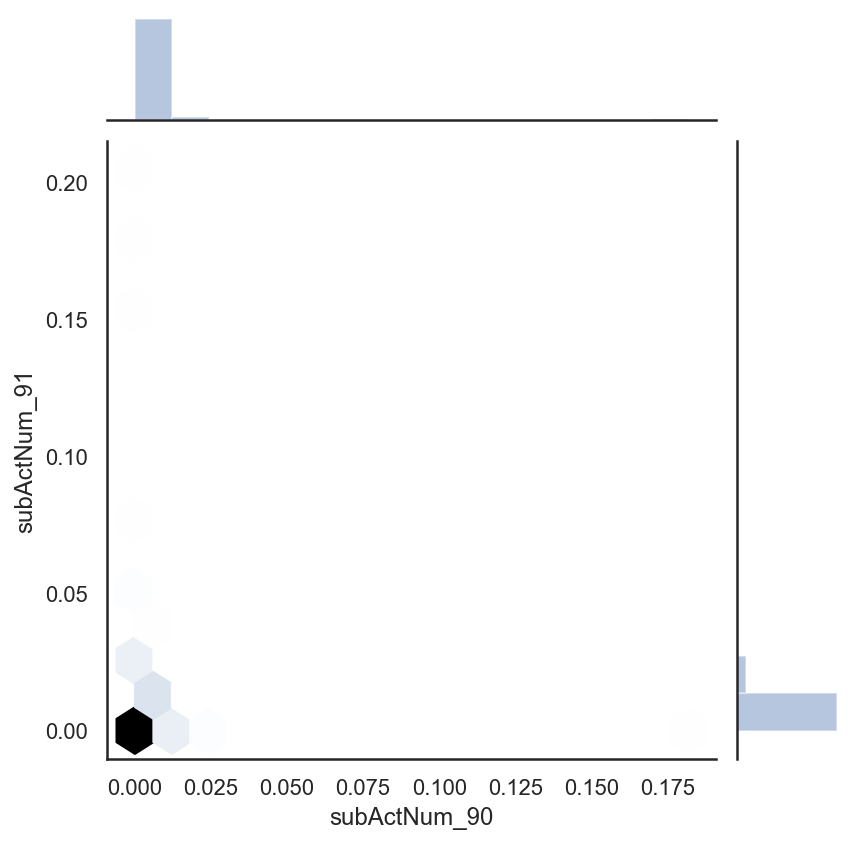

In [255]:
import numpy as np, pandas as pd; np.random.seed(0)
import seaborn as sns; sns.set(style = "white", color_codes = True)
g = sns.jointplot(x = "subActNum_90", y = "subActNum_91", data = resampleFreq, kind = "hex")

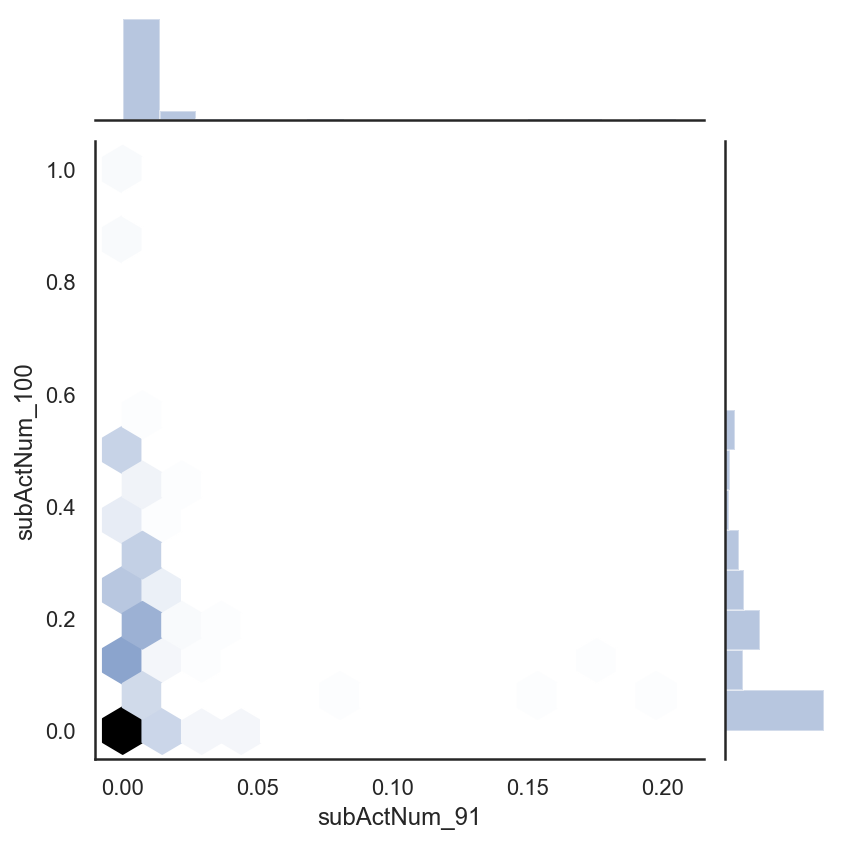

In [252]:
g = sns.jointplot(x = "subActNum_91", y = "subActNum_100", data = resampleFreq, kind = "hex")

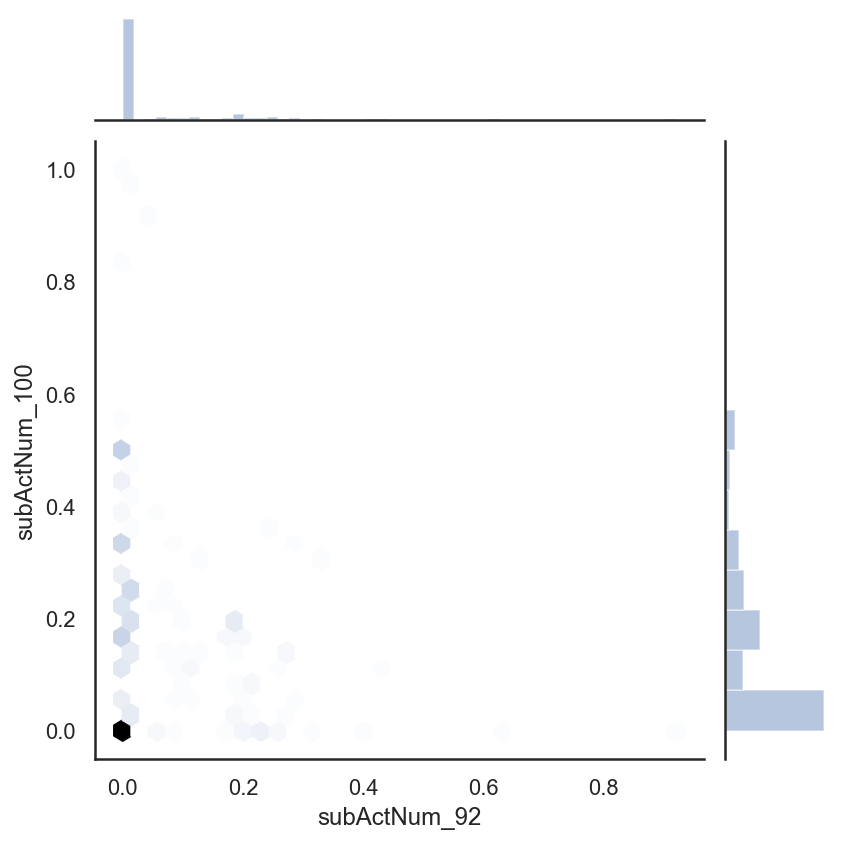

In [260]:
g = sns.jointplot(x = "subActNum_92", y = "subActNum_100", data = resampleFreq, kind = "hex")

In [259]:
os.getcwd()

'/Users/alistairgj/Documents/GitHub/ResearchProject'

In [181]:
%%R
library(ggplot2)
library(readr)

In [184]:
%%R
#final_with_cat <- read_csv("Documents/GitHub/ResearchProject/final_with_cat.csv")
#resampleFreqR <- read_csv("Documents/GitHub/ResearchProject/resampled_freq.csv")


Error: 'Documents/GitHub/ResearchProject/resampled_freq.csv' does not exist in current working directory ('/Users/alistairgj/Documents/GitHub/ResearchProject').


## All of the activities performed in 1 hour
### Frequency 

Date | Hour | # Activities | FR_100 | FR_101 | FR_102 | ... 

* Something occuring for the whole hour will have a frequency of 60 ... 


In [165]:
resampleFreq.head(n=10)

subActNum_100  subActNum_101  subActNum_104  \
2003-03-27 06:00:00       0.340426       0.340426            0.0   
2003-03-27 07:00:00       0.202073       0.243523            0.0   
2003-03-27 08:00:00       0.333333       0.000000            0.0   
2003-03-27 09:00:00       0.333333       0.000000            0.0   
2003-03-27 10:00:00       0.333333       0.000000            0.0   

                     subActNum_105  subActNum_106  subActNum_107  \
2003-03-27 06:00:00            0.0            0.0            0.0   
2003-03-27 07:00:00            0.0            0.0            0.0   
2003-03-27 08:00:00            0.0            0.0            0.0   
2003-03-27 09:00:00            0.0            0.0            0.0   
2003-03-27 10:00:00            0.0            0.0            0.0   

                     subActNum_108  subActNum_118  subActNum_119  \
2003-03-27 06:00:00            0.0            0.0            0.0   
2003-03-27 07:00:00            0.0            0.0            0.0   
2003-03-27 08:00:00            0.0            0.0            0.0   
2003-03-27 09:00:00            0.0            0.0            0.0   
2003-03-27 10:00:00            0.0            0.0            0.0   

                     subActNum_120  ...  subActNum_90  subActNum_91  \
2003-03-27 06:00:00            0.0  ...           0.0      0.000000   
2003-03-27 07:00:00            0.0  ...           0.0      0.005181   
2003-03-27 08:00:00            0.0  ...           0.0      0.000000   
2003-03-27 09:00:00            0.0  ...           0.0      0.000000   
2003-03-27 10:00:00            0.0  ...           0.0      0.000000   

                     subActNum_92  subActNum_93  subActNum_94  subActNum_95  \
2003-03-27 06:00:00           0.0      0.000000           0.0           0.0   
2003-03-27 07:00:00           0.0      0.005181           0.0           0.0   
2003-03-27 08:00:00           0.0      0.000000           0.0           0.0   
2003-03-27 09:00:00           0.0      0.000000           0.0           0.0   
2003-03-27 10:00:00           0.0      0.000000           0.0           0.0   

                     subActNum_96  subActNum_97  subActNum_98  subActNum_99  
2003-03-27 06:00:00           0.0           0.0           0.0           0.0  
2003-03-27 07:00:00           0.0           0.0           0.0           0.0  
2003-03-27 08:00:00           0.0           0.0           0.0           0.0  
2003-03-27 09:00:00           0.0           0.0           0.0           0.0  
2003-03-27 10:00:00           0.0           0.0           0.0           0.0  

[5 rows x 72 columns]

## All of the activities performed in 1 hour
### Probablity

Date | Hour | # Activities | PR_100 | PR_101 | PR_102 | ... 

## A Boolean network inference from time-series gene expression data using a genetic algorithm

In [ ]:
#myList.str.contains(listNew)
#myList.isin(listNew)   

myList = ['light', 'burner', 'machine', 'toaster', 'freezer', 
          'dvd', 'lamp', 'washer', 'dryer', 'exhaust', 'disposal']

unique_list = [] 
#dsS1Sensors.iloc[:,3] in myList

i = 0
j = 0
#dsS1Sensors.iloc[j,3]

while i < len(dsS1Sensors.iloc[:,3]):
    str = dsS1Sensors.iloc[i,3]
    if str in myList:
        unique_list.append(True)
    else:
        unique_list.append(False)
    i += 1


In [35]:
# Syntax for iloc indexing to finding a specific data element
# dat.iloc[row, column]

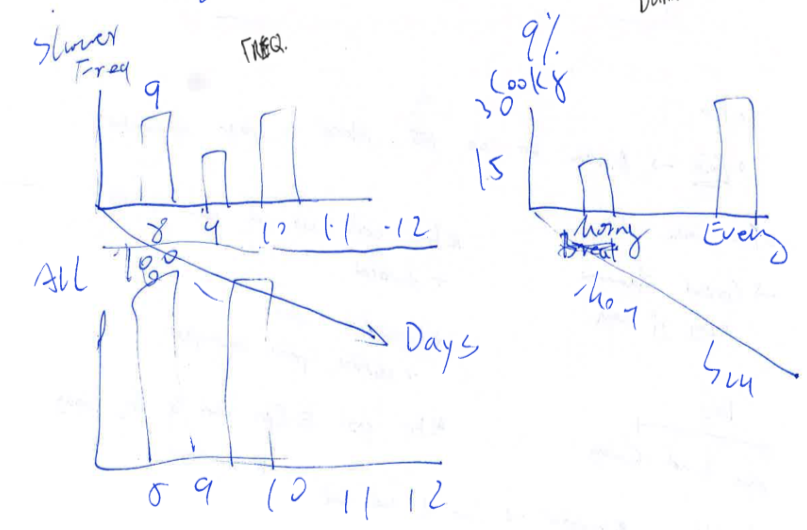

In [18]:
from IPython.display import Image
PATH = "/Users/alistairgj/Documents/GitHub/ResearchProject/"
Image(filename = PATH + "threeDFreq.png")

Index        | Requires Power?                          
----------   | ----------------              
0            | False
1            | True
2            | True
3            | True
4            | True
5            | True
6            | True
7            | True
8            | True
9            | True

Index         | Requires Power?                          
----------    | ----------------              
10            | True
11            | False
12            | True
13            | True
14            | False
15            | True
16            | False
17            | False
18            | False
19            | False
